In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from omegaconf import OmegaConf
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusion_core.guiders.guidance_editing import GuidanceEditing
from diffusion_core.utils.image_utils import load_512
from diffusion_core.schedulers.sample_schedulers import DDIMScheduler
from rembg import remove
from diffusers.image_processor import IPAdapterMaskProcessor
from diffusers.utils import load_image
import os

/home/jovyan/.mlspace/envs/material_fusion/lib/python3.8/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [3]:
scheduler = DDIMScheduler(
    num_inference_steps=50,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    set_alpha_to_one=False
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
device

device(type='cuda')

In [5]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")

In [6]:
ldm_stable = StableDiffusionPipeline.from_pretrained(
    'runwayml/stable-diffusion-v1-5',
    use_safetensors=True,
    scheduler=scheduler,
    vae = vae,
    add_watermarker=False,
).to(device)
ldm_stable.disable_xformers_memory_efficient_attention()

Keyword arguments {'add_watermarker': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [7]:
ldm_stable.disable_xformers_memory_efficient_attention()
config = OmegaConf.load('../configs/materialfusion_best.yaml')

In [8]:
image_encoder_path = "../IP-Adapter/models/image_encoder"
ip_ckpt = "../IP-Adapter/models/ip-adapter_sd15.bin"

In [9]:
guidance = GuidanceEditing(ldm_stable, config, image_encoder_path, ip_ckpt, device)

ip-adapter is set
ip-adapter is loaded


In [10]:
import os
output_folder = 'output'

# Check if the output folder exists, if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
else: 
    print("folder exists")

In [11]:
init_prompts = [
    "A photo of a Baby Yoda toy",
    ]

edit_prompts = [
    "A photo of a golden Baby Yoda toy",
    ]

In [14]:
obj_pathes = ['../example_images/objects/baby_yoda.png']
objs = ['baby_yoda']
ip_image_pathes = ['../example_images/materials/2.jpg']


In [15]:
for j in range(len(obj_pathes)):
    init_image_path = obj_pathes[j]
    init_image = Image.fromarray(load_512(init_image_path))
    init_image_name = objs[j] +'_init_image.png'
    init_image.save(init_image_name)
    rm_bg = remove(init_image)
    target_mask = rm_bg.convert("RGB").point(lambda x: 0 if x < 1 else 255).convert('L')
    target_mask_name = objs[j] + '_target_mask.png'
    target_mask.save(target_mask_name)
    mask_new = load_image(target_mask_name)
    output_height = 512
    output_width  = 512
    processor = IPAdapterMaskProcessor()
    masks = processor.preprocess([mask_new], height=output_height, width=output_width)
    masks = [masks.reshape(1, masks.shape[0], masks.shape[2], masks.shape[3])]
    init_prompt = init_prompts[j]
    print("init_prompt:", init_prompt)

    ip_image_path = ip_image_pathes[j]
    ip_image = Image.fromarray(load_512(ip_image_path))
    edit_prompt = edit_prompts[j]
    print("edit_prompt:", edit_prompt)
    scales = [0.5, 0.8, 1.0]
    for scale in scales:
        res = guidance(init_image, init_prompt, edit_prompt, ip_image, scale = scale, verbose=True, background_mask = 40, cross_attention_kwargs={"ip_adapter_masks": masks})
        image_name = 'm_' + objs[j] + str(scale) +'.png'
        save_path = 'output/' + image_name
        plt.imsave(save_path, res)

init_prompt: A photo of a Baby Yoda toy
edit_prompt: A photo of a golden Baby Yoda toy


Editing:   0%|          | 0/50 [00:00<?, ?it/s]

Editing:   0%|          | 0/50 [00:00<?, ?it/s]

Editing:   0%|          | 0/50 [00:00<?, ?it/s]

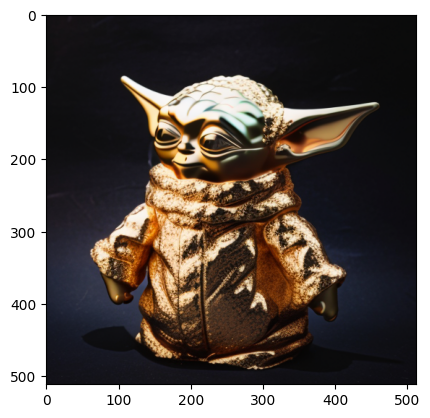

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('output/m_baby_yoda0.8.png')
imgplot = plt.imshow(img)
plt.show()

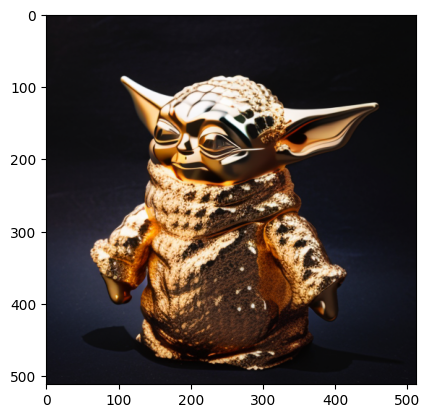

In [36]:
img = mpimg.imread('output/m_baby_yoda1.0.png')
imgplot = plt.imshow(img)
plt.show()